# DCT-based Transform Coding of Images

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Show basis functions of the DCT

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import chain
from scipy import fftpack
import scipy as sp

from ipywidgets import interactive, HBox, Label
import ipywidgets as widgets
%matplotlib inline

Functions that implement the 2D-DCT and IDCT of type-2 as they are being used in the JPG standard with (see also https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html)
$$
X_{u,v} = f(u)f(v)\sum_{k=0}^{M-1}\sum_{\ell=0}^{M-1}x[k,\ell]\cos\left(\frac{\pi u(2k+1)}{2M}\right)\cos\left(\frac{\pi v(2\ell+1)}{2M}\right)
$$
with
$$
f(x) = \begin{cases}
\sqrt{\frac{1}{M}} & \text{if }k=0 \\
\sqrt{\frac{2}{M}} & \text{otherwise}
\end{cases}
$$
which is, up to a scaling factor, the DCT used in JPG.
Note that the 2D-DCT is decomposable, i.e., we can first execute it on a 2D block in one dimension and then execute the transform in another dimension

In [4]:
def dct(x):
    retval = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            for k in range(x.shape[0]):
                for l in range(x.shape[1]):
                    retval[i,j] += x[k,l] * np.cos(np.pi*i*(2*k+1)/2/x.shape[0]) * np.cos(np.pi*j*(2*l+1)/2/x.shape[1])

            if i == 0:
                retval[i,j] *= np.sqrt(1/x.shape[0])
            else:
                retval[i,j] *= np.sqrt(2/x.shape[0])
            if j == 0:
                retval[i,j] *= np.sqrt(1/x.shape[0])
            else:
                retval[i,j] *= np.sqrt(2/x.shape[0])
    return retval    


def idct(X):
    temp = np.zeros_like(X)
    # IDCT in horizontal direction
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            temp[i,j] = X[i,0] / np.sqrt(X.shape[1])
            for k in range(1,X.shape[1]):
                temp[i,j] += X[i,k] * np.cos(np.pi*k*(2*j+1)/2/X.shape[1]) * np.sqrt(2/X.shape[1])
    
    # IDCT in vertical direction
    retval = np.zeros_like(X)
    for j in range(X.shape[1]):
        for i in range(X.shape[0]):
            retval[i,j] = temp[0,j] / np.sqrt(X.shape[0])
            for k in range(1,X.shape[0]):
                retval[i,j] += temp[k,j] * np.cos(np.pi*k*(2*i+1)/2/X.shape[0]) * np.sqrt(2/X.shape[0])
                   
    return retval    

Verify that the DCT and IDCT are indeed the same functions

In [5]:
x = np.random.randn(8,8)
X = dct(x)
xh = idct(X)

print(x-xh)

[[-2.22044605e-16  9.71445147e-16  0.00000000e+00  6.10622664e-16
  -6.66133815e-16  4.44089210e-16  2.22044605e-16 -6.66133815e-16]
 [ 2.22044605e-16 -4.44089210e-16 -5.55111512e-16 -2.77555756e-16
   6.66133815e-16  6.66133815e-16 -1.38777878e-16  0.00000000e+00]
 [ 4.44089210e-16 -6.66133815e-16 -1.11022302e-16  4.44089210e-16
   9.99200722e-16 -2.22044605e-15 -1.99840144e-15  4.44089210e-16]
 [-1.11022302e-16  6.66133815e-16 -5.55111512e-16  1.11022302e-15
  -1.11022302e-15 -1.52655666e-16  7.21644966e-16 -6.66133815e-16]
 [-6.93889390e-17 -5.13478149e-16  4.71844785e-16  1.05471187e-15
  -8.88178420e-16  2.22044605e-16  5.62050406e-16  0.00000000e+00]
 [ 3.60822483e-16 -1.11022302e-15 -7.21644966e-16  3.33066907e-16
   2.22044605e-15 -9.99200722e-16 -1.11022302e-15  3.55271368e-15]
 [ 3.88578059e-16 -3.88578059e-16 -1.11022302e-15  0.00000000e+00
   8.88178420e-16 -2.22044605e-16 -4.44089210e-16  8.88178420e-16]
 [-1.99840144e-15  1.22124533e-15  1.99840144e-15  0.00000000e+00
  -

Show basis functions of DCT

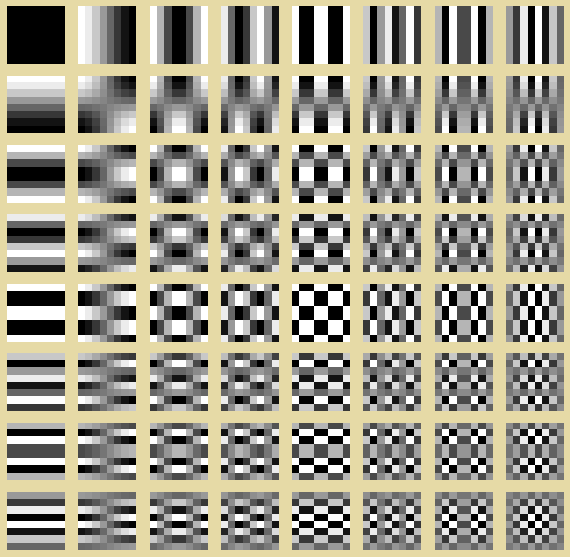

In [6]:
fig = plt.figure(1,figsize=(10,10))
fig.patch.set_facecolor('xkcd:beige')
idx = 1
for i in range(8):
    for j in range(8):
        X = np.zeros((8,8))
        X[i,j] = 1
        xh = idct(X)
        
        plt.subplot(8,8,idx)        
        plt.imshow(xh, cmap='gray')        
        plt.axis('off')
        
        idx += 1
plt.savefig('2dDCT_basis_functions.pdf', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')

---

Decompose image into blocks of size $8\times 8$ and display the DCT coefficients of these blocks

In [16]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

image = rgb2gray( mpimg.imread('Mandrill.png') )
# crop image to be a multiple of 8
image_len0 = int(np.floor(image.shape[0] / 8) * 8)
image_len1 = int(np.floor(image.shape[1] / 8) * 8)

image = image[0:image_len0, 0:image_len1]

Fast DCT implementation using scipy

In [17]:
def dct2(x):
    return sp.fftpack.dct( sp.fftpack.dct( x, axis=0, norm='ortho' ), axis=1, norm='ortho' )
            
def idct2(x):
    return sp.fftpack.idct( sp.fftpack.idct( x, axis=0 , norm='ortho'), axis=1 , norm='ortho')

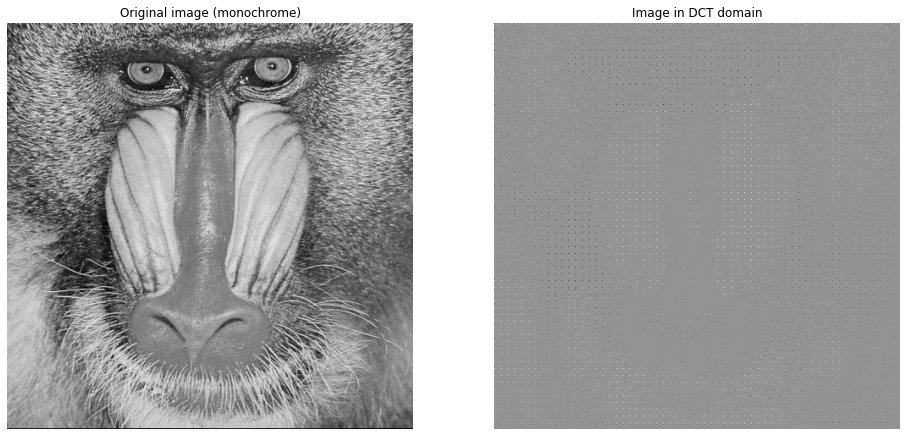

In [23]:
# show DCT
image_dct = np.zeros_like(image)
    
for start0 in np.arange(0,image.shape[0], 8):
    for start1 in np.arange(0,image.shape[1], 8):                      
        # carry out transform
        TC =  dct2(image[start0:(start0+8), start1:(start1+8)] - 0.5) 
        image_dct[start0:(start0+8), start1:(start1+8)] = TC

plt.figure(1,figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original image (monochrome)')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image_dct, cmap='gray')
plt.title('Image in DCT domain')
plt.axis('off')
plt.savefig('image_in_DCT_domain.pdf', bbox_inches='tight')